# EDA
Or whatever. PLaying around with some data

**Important:** The csv used for this analysis has tweet's texts truncated. <br>This issue has been solved for the next twitter retrieval season but this csv still got that problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
# !pip install raceplotly
from raceplotly.plots import barplot

import string
import re
import os

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('vader_lexicon')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data file path
file_path = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/twitter/raw_tweets.csv'
cols = ['tweet_id',
        'text',
        'screen_name',
        'followers',
        'retweet_count',
        'favorite_count',
        'created_at',
        'source']

In [3]:
# First view of the df
tweets = pd.read_csv(file_path, parse_dates=['created_at'], names=cols)
all_data = tweets.copy()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646786 entries, 0 to 646785
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   tweet_id        646786 non-null  int64         
 1   text            646786 non-null  object        
 2   screen_name     646786 non-null  object        
 3   followers       646786 non-null  int64         
 4   retweet_count   646786 non-null  int64         
 5   favorite_count  646786 non-null  int64         
 6   created_at      646786 non-null  datetime64[ns]
 7   source          639333 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 39.5+ MB


In [4]:
data = (all_data[(all_data['created_at'] >= '2021-02-24 00:00:00') & (all_data['created_at'] <= '2021-02-24 12:00:00')]
        .reset_index()
        .drop('index', axis=1)
       )

In [5]:
def first_cleaning(df):
    """It returns a DataFrame after dropping duplicates (subset=['tweet_id']) and sorting it (by='tweet_id')
    
    Parameters
    ----------
    df : Pandas DataFrame to clean
    """
    df_no_dup = df.drop_duplicates(subset=['tweet_id'], ignore_index=True)
    cleaned_df = df_no_dup.sort_values(by='tweet_id', ignore_index=True)
    return cleaned_df


def re_cleaning_round(text):
    """It returns a string without hashtags, new line characters, @ mentions and urls."""
    text = re.sub('#', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('@\\w+ *', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\s+', ' ', text)
    
    return text

re_cleaning = lambda x: re_cleaning_round(x)


def rt_counter(df):
    """It returns how many retweets (RT) are in the column 'text' of a given DataFrame."""
    pattern = '^RT :.*'
    count = 0
    
    for text in df['text']:
        if re.match(pattern, text):
            count += 1
    return count


def rt_dropper(df):
    """It returns a NEW DataFrame with no retweets in it. It does not modify the one passed to it."""
    pattern = '^RT :.*'
    rows = []
    
    for i, text in enumerate(df['text']):
        if re.match(pattern, text):
            rows.append(i)
    return df.drop(rows).reset_index().drop('index', axis=1)

In [6]:
length_b = data.shape[0]
# We apply some cleaning on the dataset
data = first_cleaning(data)
length_a = data.shape[0]
print(f'Number of tweets before dropping duplicates: {length_b}')
print(f'Number of unique tweets: {length_a}')
print('-' * 30)
print(f'Number of duplicate tweets: {length_b - length_a}')

Number of tweets before dropping duplicates: 25212
Number of unique tweets: 25212
------------------------------
Number of duplicate tweets: 0


In [7]:
# We apply a second round of cleaning.
# Now, with RegEx. we are able to clean the texts from basic typos and shit people post on social media.
data['text'] = data['text'].apply(re_cleaning_round)

In [8]:
print(data.shape)
data.sample(3)

(25212, 8)


tweet_id                                               text  \
19078  1364497821953626113  RT : Hey Greetings from THE GREENHUB Community...   
1837   1364374531125698562  RT : Check out my Cryptocurrency guides playli...   
14387  1364460491901313027  Financial services outfit Square just announce...   

         screen_name  followers  retweet_count  favorite_count  \
19078  Aleks41622845        253           5540               0   
1837    TriHardMusic        533            507               0   
14387   Crypto_Chic_         61              0               0   

               created_at           source  
19078 2021-02-24 08:50:06  Twitter Web App  
1837  2021-02-24 00:40:11  Twitter Web App  
14387 2021-02-24 06:21:46  Twitter Web App

In [9]:
data['text'][13925]

'RT : 🏴\u200d☠️•UPDATE•🏴\u200d☠️ One thousand investors🙏🏻 the biggest current equity on Covesting, and it’s all due to risk management and a…'

We got a tweet from Elon! How exciting :))))

In [10]:
data_no_rt = rt_dropper(data)
print(data_no_rt.shape)
data_no_rt.sample(3)

(10405, 8)


tweet_id                                               text  \
9670   1364530008572776448                $BTC Triggered his decision to sell   
10128  1364541526634868736  $BTC my opinion $46800👌 not investment advice ...   
8531   1364510493327638528  A n d I'm so thankful for this!! 😍😍😍😍😍😍😍 Let’s...   

         screen_name  followers  retweet_count  favorite_count  \
9670      cw30720668         76              0               0   
10128  Bitcoin__Gold        165              0               0   
8531         tiba765       3304              0               0   

               created_at              source  
9670  2021-02-24 10:58:00  Twitter for iPhone  
10128 2021-02-24 11:43:46     Twitter Web App  
8531  2021-02-24 09:40:27     Twitter Web App

### Retweets vs no retweets

Text(0, 0.5, 'Count')

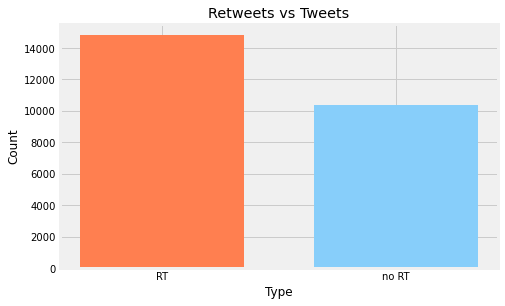

In [11]:
freq = rt_counter(data), len(data) - rt_counter(data)
classes = ('RT', 'no RT')

plt.figure(figsize=(7, 4.5))
plt.bar(classes, freq, width=0.7, color=['coral','lightskyblue'])

plt.title('Retweets vs Tweets');
plt.xlabel('Type')
plt.ylabel('Count')

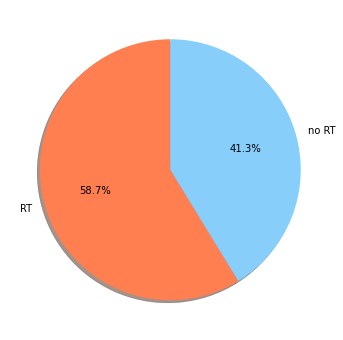

In [12]:
labels = ['RT', 'no RT']
sizes = rt_counter(data), len(data) - rt_counter(data)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['coral','lightskyblue']);

### Tweet source
Where people is posting bitcoin tweets from

In [13]:
sources = len(data['source'].value_counts())
print(f'Bitcoin related tweets were posted from {sources} different sources. Most of them are bots')

Bitcoin related tweets were posted from 406 different sources. Most of them are bots


In [14]:
# Main sources where people post tweets from
def tweet_sources(df, n_sources=5):
    """It returns a dictionary with the main sources used by people to post bitcoin related tweets as keys, and their counts as values.
    
    Parameters
    ----------
    df : DataFrame that contains a column named "source".
    n_sources : Length of the returned dictionary
    """
    sources = df['source'].value_counts().index
    counts = df['source'].value_counts().values

    main_sources = {}
    counter = 0

    for source, count in zip(sources, counts):
        counter += 1
        if counter <= n_sources:
            main_sources[source] = count
        else:
            break

    return main_sources

In [15]:
main_sources = tweet_sources(data, 10)
main_sources

{'Twitter for Android': 7893,
 'Twitter for iPhone': 7797,
 'Twitter Web App': 6485,
 'Twitter for iPad': 270,
 'ContentStudio.io': 191,
 'IFTTT': 184,
 'dlvr.it': 151,
 'TweetDeck': 122,
 'Twitter for Mac': 78,
 'Arbing Tool': 68}

Text(0, 0.5, 'Source')

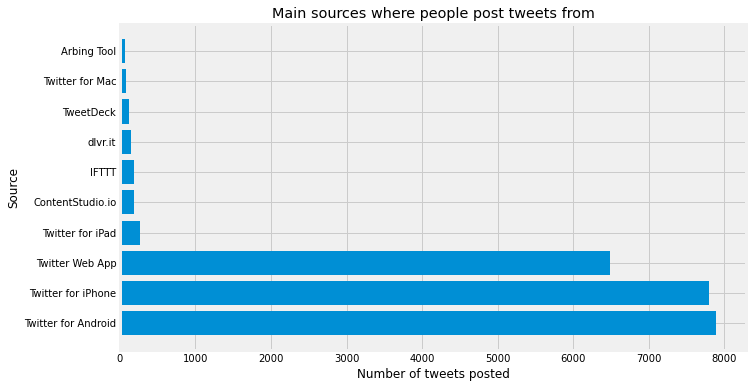

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(list(main_sources.keys()), list(main_sources.values()))

plt.title('Main sources where people post tweets from')
plt.xlabel('Number of tweets posted')
plt.ylabel('Source')

### Number of users who posted about bitcoin 
and how many times each one of those

In [17]:
len(data['screen_name']), data['screen_name'].nunique()

(25212, 17619)

In [18]:
one_tweet_people = (data['screen_name'].value_counts() == 1).sum()
print(f'{one_tweet_people} users posted bitcoin related tweets just once.')

14460 users posted bitcoin related tweets just once.


In [19]:
# How many times users posted a tweet in the period of study
unique_users = data['screen_name'].value_counts().value_counts().sort_values(ascending=False)
unique_users = unique_users.to_frame().reset_index()
unique_users.columns = ['tweets', 'users']
unique_users.head(5)

tweets  users
0       1  14460
1       2   1915
2       3    603
3       4    280
4       5    103

In [20]:
tweeter = unique_users['tweets'].max()
print(f'One user posted {tweeter} tweets just himself. Impressive!')

One user posted 186 tweets just himself. Impressive!


Text(0, 0.5, 'Number of people')

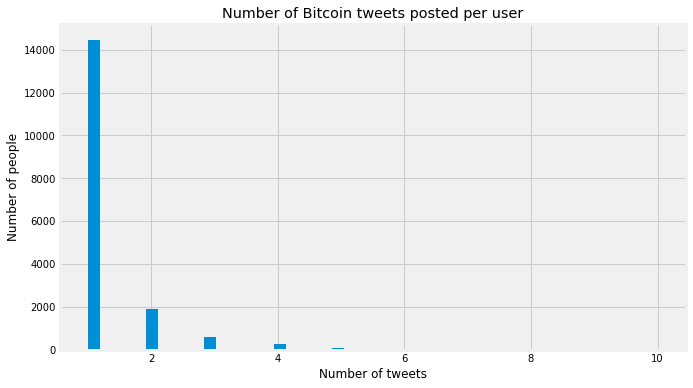

In [21]:
plt.figure(figsize=(10, 6))

plt.hist(data['screen_name'].value_counts().values, bins=np.linspace(1, 10, 50));
# plt.xlim(0, 20)
# plt.xticks(np.arange(0, 20))

plt.title('Number of Bitcoin tweets posted per user')
plt.xlabel('Number of tweets')
plt.ylabel('Number of people')

Text(0, 0.5, 'Number of people')

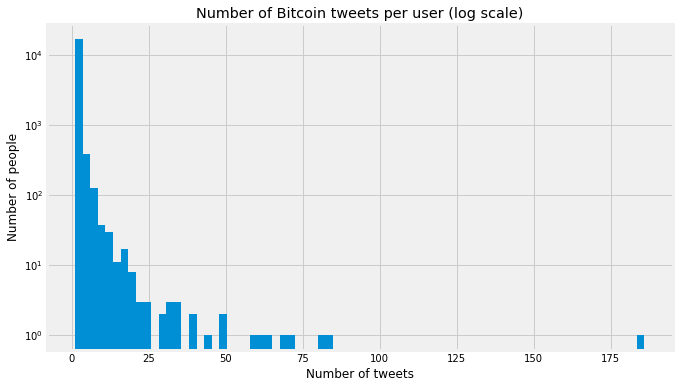

In [22]:
plt.figure(figsize=(10, 6))

plt.hist(data['screen_name'].value_counts().values, bins=75);
plt.yscale('log')

plt.title('Number of Bitcoin tweets per user (log scale)')
plt.xlabel('Number of tweets')
plt.ylabel('Number of people')

### Tweets length

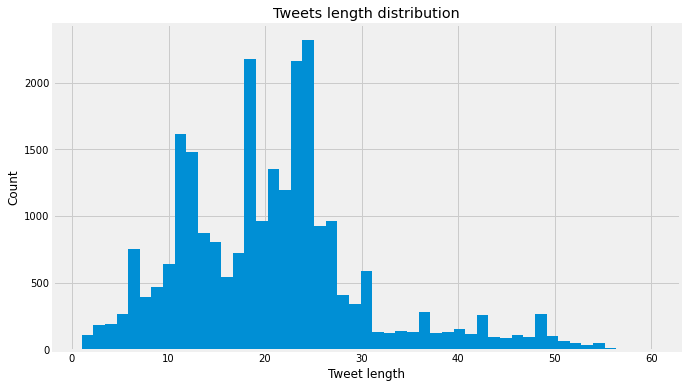

In [23]:
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=np.linspace(1, 60, 50))
# plt.yscale('log')
plt.title('Tweets length distribution')
plt.xlabel('Tweet length')
plt.ylabel('Count');
# px.histogram(data['length'], template='plotly_dark')

### Tweets distribution over time

In [24]:
# Per hour
data['hour'] = data['created_at'].dt.hour
# # Per weekday
day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = data['created_at'].dt.weekday
data['weekday'] = data['weekday'].apply(lambda x: day_name[x])
# # Per monthday
data['day'] = data['created_at'].dt.day

# # Matplotlib plots
# plt.figure(figsize=(10, 6))
# # plt.hist(data['hour'], bins=24);
# plt.hist(data['weekday']);
# plt.hist(data['day']);

# Plotly plots
# px.histogram(data, x='hour', template='plotly_dark')
px.histogram(data, x='hour', template='plotly_dark')

In [25]:
data.head()

tweet_id                                               text  \
0  1364367666501218304  bitcoin -Over 2B off opening interest across f...   
1  1364367668472520704  RT : ⚡$10,000 Giveaway⚡ To celebrate 50k membe...   
2  1364367669097467907             The current vibe $eth $link $btc pepe    
3  1364367670871736320  RT : Haven’t given anything away in a while so...   
4  1364367672704573442  RT : Bitcoin will eventually hit $1 million. I...   

       screen_name  followers  retweet_count  favorite_count  \
0   Trader_Recluse        208              0               0   
1      hellokamu__         50          12177               0   
2  jairgonzalezbot         20              0               0   
3   TophTophington         24            122               0   
4         arfitsaa          0            709               0   

           created_at               source  length  hour    weekday  day  
0 2021-02-24 00:12:55      Twitter Web App      30     0  Wednesday   24  
1 2021-02-24 00:12:55  Twitter for Android      22     0  Wednesday   24  
2 2021-02-24 00:12:55   Twitter for iPhone       8     0  Wednesday   24  
3 2021-02-24 00:12:56   Twitter for iPhone      23     0  Wednesday   24  
4 2021-02-24 00:12:56   Twitter for iPhone      14     0  Wednesday   24

# Sentiment analysis: Polarity Scores

**A little testing**

In [26]:
sentence = 'A long time ago in a galaxy far, far away…'
tokens = nltk.word_tokenize(sentence)
tokens

['A', 'long', 'time', 'ago', 'in', 'a', 'galaxy', 'far', ',', 'far', 'away…']

### Testing Polarity Scores with VADER & TextBlob

In [27]:
# Testing VADER
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores('you suck')

{'neg': 0.744, 'neu': 0.256, 'pos': 0.0, 'compound': -0.4404}

In [28]:
# Testing TextBlob
opinion = TextBlob('you suck')
opinion.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [29]:
# Examples
ex1 = data_no_rt['text'][np.random.randint(0, data_no_rt.shape[0])]
ex2 = data_no_rt['text'][np.random.randint(0, data_no_rt.shape[0])]
ex3 = data_no_rt['text'][np.random.randint(0, data_no_rt.shape[0])]

print(ex1)
print('*' * 50)
print(ex2)
print('*' * 50)
print(ex3)

Cool, I hope it goes well for you mate!
**************************************************
Welcome to bitcoin! Hold a long time and the loses are massive! But the gains are too!
**************************************************
The issue with Bitcoin is that it’s no longer a money maker. To just gain 100% profit, it has to add another trillion dollars to its market cap. If you want to make money at this point you gotta go with a smaller cap crypto.


In [30]:
# Testing VADER polarity
examples = [ex1, ex2, ex3]
for ex in examples:
    print(analyzer.polarity_scores(ex)['compound'])
    print('*' * 10)

0.7644
**********
0.6093
**********
0.6597
**********


In [31]:
# Testing TextBlob polarity
for ex in examples:
    opinion = TextBlob(ex)
    print(opinion.sentiment[0])
    print('*' * 10)

0.4375
**********
0.16249999999999998
**********
0.0
**********


It looks like VADER polarity scores could work better on social media emotions.

In [32]:
# Creating a new DataFrame to add the scores.
df_scores = pd.DataFrame()
df_scores['date'] = data['created_at']
df_scores['id'] = data['tweet_id']
df_scores['text'] = data['text']
df_scores['followers'] = data['followers']
df_scores['likes'] = data['favorite_count']
# Setting rigth types
df_scores = df_scores.astype({'followers': 'int32', 'likes': 'int32'})

In [33]:
df_scores.sample(3)

date                   id  \
23653 2021-02-24 11:18:43  1364535221576638469   
7394  2021-02-24 02:44:33  1364405827075903489   
2279  2021-02-24 00:41:48  1364374935129501699   

                                                    text  followers  likes  
23653  RT : If this gets 500 retweets, I'll give one ...        629      0  
7394   RT : Bitcoin is back over $50,000. Retweet if ...         22      0  
2279   $2 would be life changing. I still wouldn't se...       1646      0

### Adding polarity scores to our DataFrame

In [34]:
def vader_polarity(text):
    return analyzer.polarity_scores(text)['compound']

get_v_polarity = lambda x: vader_polarity(x)

def textblob_polarity(text):
    return TextBlob(text).sentiment[0]

get_tb_polarity = lambda x: textblob_polarity(x)

In [35]:
# This takes some time
df_scores['vader_polarity'] = df_scores['text'].apply(get_v_polarity)
df_scores['textblob_polarity'] = df_scores['text'].apply(get_tb_polarity)

In [36]:
# Instead we're going to read csv we already saved before
# scores_path = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/twitter/scored_tweets.csv'
# df_scores = pd.read_csv(scores_path)

In [37]:
df_scores.info()
df_scores.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25212 entries, 0 to 25211
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               25212 non-null  datetime64[ns]
 1   id                 25212 non-null  int64         
 2   text               25212 non-null  object        
 3   followers          25212 non-null  int32         
 4   likes              25212 non-null  int32         
 5   vader_polarity     25212 non-null  float64       
 6   textblob_polarity  25212 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(1)
memory usage: 1.2+ MB


date                   id  \
0 2021-02-24 00:12:55  1364367666501218304   
1 2021-02-24 00:12:55  1364367668472520704   
2 2021-02-24 00:12:55  1364367669097467907   

                                                text  followers  likes  \
0  bitcoin -Over 2B off opening interest across f...        208      0   
1  RT : ⚡$10,000 Giveaway⚡ To celebrate 50k membe...         50      0   
2             The current vibe $eth $link $btc pepe          20      0   

   vader_polarity  textblob_polarity  
0          0.0258            -0.1875  
1          0.5719             0.0000  
2          0.0000             0.0000

In [38]:
df_scores['text'][0]

'bitcoin -Over 2B off opening interest across futures and derivatives -prices stabilizing around a daily level -weak longs deleted from the market -Saylor &amp; Co plunge protection.exe Whats bearish? '

### People's emotions

In [39]:
# Get an emotion column
def label_emotion(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    return 'Neutral'        

df_scores['emotion'] = df_scores['vader_polarity'].apply(lambda x: label_emotion(x))

In [40]:
emotions = df_scores['emotion'].value_counts(ascending=True)

# plt.bar(x=emotions.index,
#         height=emotions.values,
#         color=['darkorange', 'deepskyblue', 'limegreen'])
# plt.title('Type of emotions in Bitcoin Tweets')
# plt.xlabel('Emotion')
# plt.ylabel('Count')

px.bar(emotions,
       x=emotions.index,
       y=emotions.values,
       color=emotions.index,
       template='plotly_dark',
       labels={'index':'Emotions','y':'Number of comments'})

We can see that, overall, people's emotions on Bitcoin in social media are mostly positive. That could be explained due to Bitcoin prices increase durind the period of Twitter extraction.

### People's emotions over time

In [41]:
# Let's create a new DataFrame to carry out this task
df_emotions = pd.DataFrame()
df_emotions['weekday'] = data['weekday']
df_emotions['day'] = data['day']
df_emotions['hour'] = data['hour']
df_emotions['emotion'] = df_scores['emotion']
df_emotions.head(3)

weekday  day  hour   emotion
0  Wednesday   24     0  Positive
1  Wednesday   24     0  Positive
2  Wednesday   24     0   Neutral

In [42]:
df_weekday = df_emotions.groupby(['weekday', 'emotion'])['hour'].count()
df_weekday = df_weekday.to_frame(name='count').reset_index()
df_day = df_emotions.groupby(['day', 'emotion'])['hour'].count()
df_day = df_day.to_frame(name='count').reset_index()

interactive_plot = barplot(df_day, item_column='emotion', value_column='count', time_column='day')

interactive_plot.plot(title='Tweets emotions over days',
                      item_label='Emotions',
                      value_label='Tweets count',
                      frame_duration=60)

### Word Cloud for different emotions

For WordClouds to be intuitive and clear enough we will have to clean our tweets once more in order to remove capital letters, stop words, punctuation, words containing numbers, etc. <br>
Just as a reminder, we did not perform this cleaning before because polarity scores in VADER also work with this kind of language.

Let's get to it!

**First, we create a new df to work with**

In [43]:
df_texts = pd.DataFrame()
df_texts['date'] = df_scores['date']
df_texts['id'] = df_scores['id']
df_texts['text'] = df_scores['text']
df_texts['emotion'] = df_scores['emotion']

In [44]:
def is_rt(text):
    """It returns 1 if text is retweet and 0 if it is not."""
    pattern = '^RT :.*'
    if re.match(pattern, text):
        return 1
    return 0

df_texts['retweet'] = df_texts['text'].apply(lambda x: is_rt(x))

In [45]:
df_texts['retweet'].value_counts()

1    14807
0    10405
Name: retweet, dtype: int64

In [46]:
df_texts.head()

date                   id  \
0 2021-02-24 00:12:55  1364367666501218304   
1 2021-02-24 00:12:55  1364367668472520704   
2 2021-02-24 00:12:55  1364367669097467907   
3 2021-02-24 00:12:56  1364367670871736320   
4 2021-02-24 00:12:56  1364367672704573442   

                                                text   emotion  retweet  
0  bitcoin -Over 2B off opening interest across f...  Positive        0  
1  RT : ⚡$10,000 Giveaway⚡ To celebrate 50k membe...  Positive        1  
2             The current vibe $eth $link $btc pepe    Neutral        0  
3  RT : Haven’t given anything away in a while so...  Negative        1  
4  RT : Bitcoin will eventually hit $1 million. I...   Neutral        1

**Second we clean it**

In [47]:
# Stop Words
stop_words = stopwords.words('english')
more_stopwords = ['bitcoin', 'btc', 'eth', 'retweet', 'rt']
stop_words = stop_words + more_stopwords

# Stemming
stemmer = nltk.SnowballStemmer("english")

In [48]:
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers."""
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


def deEmojify(text):
    """It removes emojis from a given text."""
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)


def remove_stopwords(text):
    """Removes nltk english stop words from a given text."""
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text



def second_cleaning(text):
    """Main cleaning."""
    text = clean_text(text)
    text = deEmojify(text)
    text = remove_stopwords(text)
    text = ' '.join(text.split())
        
    return text


df_texts['text_clean'] = df_texts['text'].apply(second_cleaning)

In [49]:
df_texts.head()

date                   id  \
0 2021-02-24 00:12:55  1364367666501218304   
1 2021-02-24 00:12:55  1364367668472520704   
2 2021-02-24 00:12:55  1364367669097467907   
3 2021-02-24 00:12:56  1364367670871736320   
4 2021-02-24 00:12:56  1364367672704573442   

                                                text   emotion  retweet  \
0  bitcoin -Over 2B off opening interest across f...  Positive        0   
1  RT : ⚡$10,000 Giveaway⚡ To celebrate 50k membe...  Positive        1   
2             The current vibe $eth $link $btc pepe    Neutral        0   
3  RT : Haven’t given anything away in a while so...  Negative        1   
4  RT : Bitcoin will eventually hit $1 million. I...   Neutral        1   

                                          text_clean  
0  opening interest across futures derivatives pr...  
1  ⚡ giveaway⚡ celebrate members telegram channel...  
2                             current vibe link pepe  
3  haven’t given anything away go going give rand...  
4      eventually hit million another cryptocurrency

**Actually plot the WordCloud**

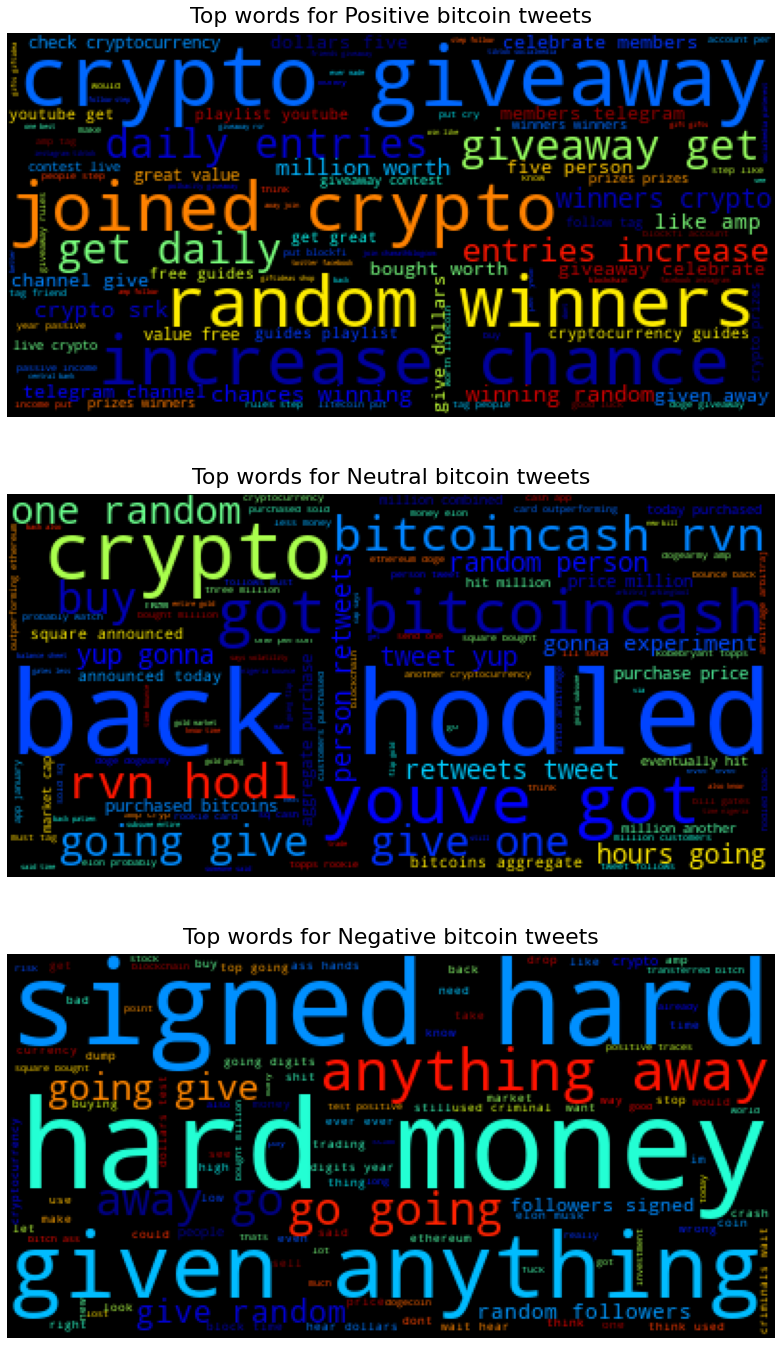

In [50]:
wc = WordCloud(background_color='black',
               max_words=100,
               max_font_size=100,
               colormap='jet',
               min_word_length=2,
               stopwords=stop_words
              )

fig, axes = plt.subplots(3, 1, figsize=(30, 24))

for index, emotion in enumerate(df_texts['emotion'].value_counts().index):
    
    wc.generate(' '.join(text for text in df_texts.loc[df_texts['emotion'] == emotion, 'text_clean']))
    
    axes[index].set_title(f'Top words for {emotion} bitcoin tweets',
                          fontdict={'size': 22,
                                    'verticalalignment': 'bottom'})
    axes[index].imshow(wc)
    axes[index].axis("off")

### Get a compound score

In [41]:
# For VADER
df_scores['vader_score'] = df_scores['vader_polarity'] * (0.1 * (df_scores['followers'] + 1)) * (0.1 * (df_scores['likes'] + 1))
# For TextBlob
df_scores['textblob_score'] = df_scores['textblob_polarity'] * (0.1 * (df_scores['followers'] + 1)) * (0.1 * (df_scores['likes'] + 1))

df_scores.head(3)

date                   id  \
0 2021-02-19 03:11:31  1362600676174557186   
1 2021-02-19 15:27:21  1362785854758993927   
2 2021-02-19 15:40:21  1362789125762539523   

                                                text  followers  likes  \
0  To be clear, I am *not* an investor, I am an e...   47430700  34993   
1  MicroStrategy Completes $1.05 Billion Offering...     508709   9653   
2             1,000,000,000,000 market cap. Bitcoin     1832692  12117   

   vader_polarity  textblob_polarity   emotion   vader_score  textblob_score  
0           -0.25           0.085714  Negative -4.149475e+09    1.422677e+09  
1            0.00           0.000000   Neutral  0.000000e+00    0.000000e+00  
2            0.00           0.000000   Neutral  0.000000e+00    0.000000e+00

In [42]:
df_scores.to_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/twitter/scored_tweets.csv', index=False)